## Generative Adversarial Networks with FashionMNIST

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torchvision
import random
import torch
import os

In [2]:
# set random seed for reproducibility
seed = 42
random.seed(seed)
torch.manual_seed(seed)

In [3]:
# determine hardware accelerator for the notebook
def get_optimal_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")
    
DEVICE = get_optimal_device()
print(f"hardware accelerator - {DEVICE.type}")

hardware accelerator - mps


In [4]:
def denorm(x):
    return torch.clamp((x + 1) / 2, min=0, max=1)

In [5]:
def save_images(generator, idx, folder_name, batch_size, latent_size, device):
    sample_vectors = torch.randn(batch_size, latent_size).to(device)
    images = generator(sample_vectors)
    images = images.reshape(-1, 1, 28, 28)
    name = "fake_images-{0:0=4d}.png".format(idx)
    torchvision.utils.save_image(denorm(images), os.path.join(folder_name, name), nrow=8)
    return images

### Part 1 - GAN

#### Step 1 - Load the FashionMNIST dataset and create the models

In [6]:
default_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=0.5, std=0.5),
    ]
)
fashion_mnist = torchvision.datasets.FashionMNIST(
    "data", train = True, download=True, transform=default_transforms
)
fashion_mnist

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

#### 1.1 Dataset Characteristics and Samples

In [7]:
# classes in the dataset
print(f"Dataset Classes - {fashion_mnist.class_to_idx}")

Dataset Classes - {'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


In [8]:
# min and max of the first image from the dataset
print(f"Image {fashion_mnist[0][0].shape} min[{fashion_mnist[0][0].min()}] max[{fashion_mnist[0][0].max()}]")

Image torch.Size([1, 28, 28]) min[-1.0] max[1.0]


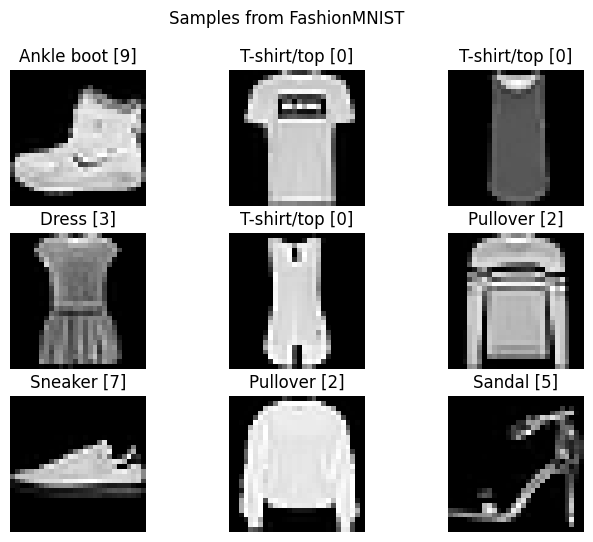

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(8, 6))
_ = fig.suptitle("Samples from FashionMNIST")

for i in range(9):
    img, label = fashion_mnist[i]
    img = denorm(img)
    img = img.permute(1, 2, 0)
    ax[i // 3][i % 3].imshow(img, cmap="gray")
    ax[i // 3][i % 3].set_title(f"{fashion_mnist.classes[label]} [{label}]")
    ax[i // 3][i % 3].axis("off")

#### 1.2 Create Discriminator and Generator models

In [11]:
# Model Parameters
IMG_SIZE = 784 # 28 * 28
HIDDEN_SIZE = 256
LATENT_SIZE = 64

In [12]:
# Creating a function so that we do not have to repeat the code
def create_discriminator(img_size, hidden_size, device):
    model = torch.nn.Sequential(
        torch.nn.Linear(in_features=img_size, out_features=hidden_size),
        torch.nn.LeakyReLU(negative_slope=0.2),
        torch.nn.Linear(in_features=hidden_size, out_features=hidden_size),
        torch.nn.LeakyReLU(negative_slope=0.2),
        torch.nn.Linear(in_features=hidden_size, out_features=1),
        torch.nn.Sigmoid(),
    )
    # move the model to GPU
    model.to(device)
    return model

In [13]:
# define the Discriminator
D = create_discriminator(IMG_SIZE, HIDDEN_SIZE, DEVICE)

In [14]:
def create_generator(latent_size, hidden_size, img_size, device):
    model = torch.nn.Sequential(
        torch.nn.Linear(in_features=latent_size, out_features=hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=hidden_size, out_features=hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=hidden_size, out_features=img_size),
        torch.nn.Tanh(),
    )
    # move the model to GPU
    model.to(device)
    return model

In [15]:
# define the Generator
G = create_generator(LATENT_SIZE, HIDDEN_SIZE, IMG_SIZE, DEVICE)

Shape of random latent vectors - torch.Size([2, 64])


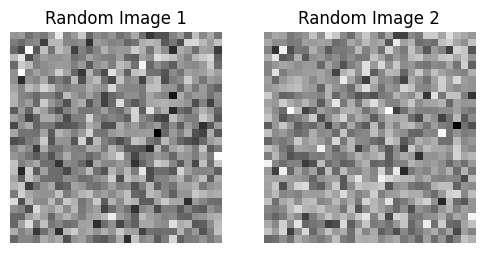

In [16]:
# generate 2 random latent vector of size LATENT_SIZE
random_latent_vectors = torch.randn((2, LATENT_SIZE)).to(DEVICE)
print(f"Shape of random latent vectors - {random_latent_vectors.shape}")
# generate images from the latent vectors
imgs = G(random_latent_vectors)
imgs = denorm(imgs)
imgs = imgs.reshape((2, 1, 28, 28)).permute(0, 2, 3, 1).to("cpu").detach()
# show the random images
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].set_title("Random Image 1")
ax[0].axis("off")
_ = ax[0].imshow(imgs[0], cmap="gray")
ax[1].set_title("Random Image 2")
ax[1].axis("off")
_ = ax[1].imshow(imgs[1], cmap="gray")

#### Step 2 -  Train the Discriminator and Generator

In [17]:
SAMPLES_FOLDER = "gan_samples"
WEIGHTS_FOLDER = "weights"
LEARNING_RATE = 0.0001
BATCH_SIZE = 256
EPOCHS = 500

In [18]:
# create the samples folder and weights folder
os.makedirs(SAMPLES_FOLDER, exist_ok=True)
os.makedirs(WEIGHTS_FOLDER, exist_ok=True)

In [19]:
# define the loss and optimizers
criterion = torch.nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=LEARNING_RATE)
g_optimizer = torch.optim.Adam(G.parameters(), lr=LEARNING_RATE)

In [20]:
# function to train the discriminator and generator
def train_gan(
    discriminator,
    generator,
    latent_size,
    dataloader,
    criterion,
    d_optimizer,
    g_optimizer,
    t_batch_size,
    start_epochs,
    end_epochs,
    device,
    samples_folder,
):
    metrics = {
        "epoch": [],
        "step": [],
        "d_loss": [],
        "g_loss": [],
        "d_real_accuracy": [],
        "d_fake_accuracy": [],
    }

    total_steps = len(dataloader)

    for epoch in range(start_epochs, end_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            # get the number of samples in this batch
            batch_size = real_images.size(0)
            # reshape the batch - example [10, 1, 28, 28] to [10, 784]
            real_images = real_images.view(batch_size, -1)
            # move the tensor to GPU
            real_images = real_images.to(device)

            # train discriminator
            d_optimizer.zero_grad()
            # labels for real images
            real_labels = torch.ones(batch_size, 1)
            # move real labels to GPU
            real_labels = real_labels.to(device)
            # predictions on the real images
            d_real_output = discriminator(real_images)
            # loss on the real images
            d_real_loss = criterion(d_real_output, real_labels)
            # latent vectors for fake images
            z = torch.randn(batch_size, latent_size)
            # move latent vector to GPU
            z = z.to(device)
            # fake images
            fake_images = generator(z)
            # labels for fake images
            fake_labels = torch.zeros(batch_size, 1)
            # move fake labels to GPU
            fake_labels = fake_labels.to(device)
            # predictions on the fake images (detach to stop gradient updates)
            d_fake_output = discriminator(fake_images.detach())
            # loss on the fake images
            d_fake_loss = criterion(d_fake_output, fake_labels)
            # combined loss
            d_loss = d_real_loss + d_fake_loss
            # calculate gradients
            d_loss.backward()
            # propagate loss backwards
            d_optimizer.step()

            # train generator
            g_optimizer.zero_grad()
            # predictions on the fake images
            g_output = discriminator(fake_images)
            # loss on the fake images
            g_loss = criterion(g_output, real_labels)
            # calculate gradients
            g_loss.backward()
            # propagate loss backwards
            g_optimizer.step()

            # calculate metrics
            d_real_accuracy = (
                ((d_real_output > 0.5).float() == real_labels).float().mean()
            )
            d_fake_accuracy = (
                ((d_fake_output < 0.5).float() == fake_labels).float().mean()
            )

            # log metrics
            metrics["epoch"].append(epoch + 1)
            metrics["step"].append(i + 1)
            metrics["d_loss"].append(d_loss.item())
            metrics["g_loss"].append(g_loss.item())
            metrics["d_real_accuracy"].append(d_real_accuracy.item())
            metrics["d_fake_accuracy"].append(d_fake_accuracy.item())

            # print progress
            if (i + 1) % (total_steps // 2) == 0:
                print(
                    f"Epoch [{epoch+1}/{end_epochs}],",
                    f"Step [{i+1}/{total_steps}],",
                    f"D Loss: {d_loss.item():.4f},",
                    f"G Loss: {g_loss.item():.4f},",
                    f"D Real Accuracy: {d_real_accuracy.item():.4f},",
                    f"D Fake Accuracy: {d_fake_accuracy.item():.4f}",
                )
        # save fake samples for progress
        _ = save_images(
            generator, epoch + 1, samples_folder, t_batch_size, latent_size, device
        )

    return metrics

In [21]:
# create the dataloader for training
dataloader = torch.utils.data.DataLoader(fashion_mnist, batch_size=BATCH_SIZE, shuffle=True)

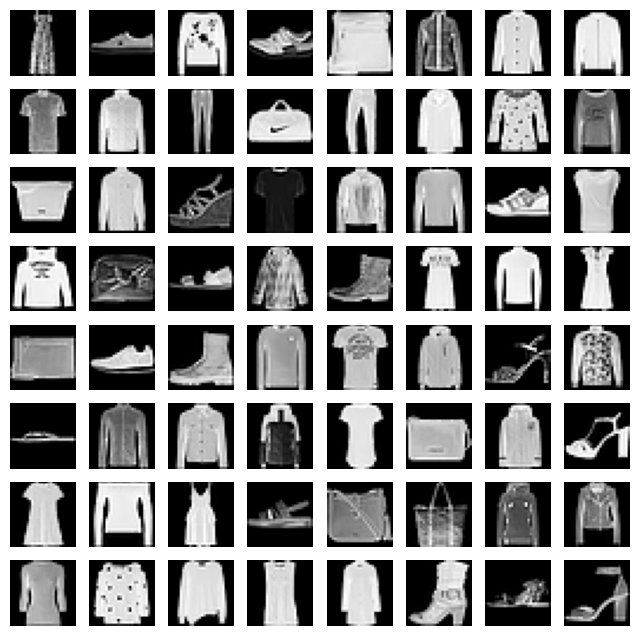

In [22]:
# save samples of real_images
real_image_path = os.path.join(SAMPLES_FOLDER, "real_images.png")
image_samples = None
for images, _ in dataloader:
    images = images.reshape(-1, 1, 28, 28)
    torchvision.utils.save_image(denorm(images[:64]), real_image_path, nrow=8)
    image_samples = images[:64]
    break

# show the samples here
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(len(image_samples)):
    image = image_samples[i].permute(1, 2, 0)
    image = denorm(image)
    ax[i // 8][i % 8].axis("off")
    _ = ax[i // 8][i % 8].imshow(image, cmap="gray")

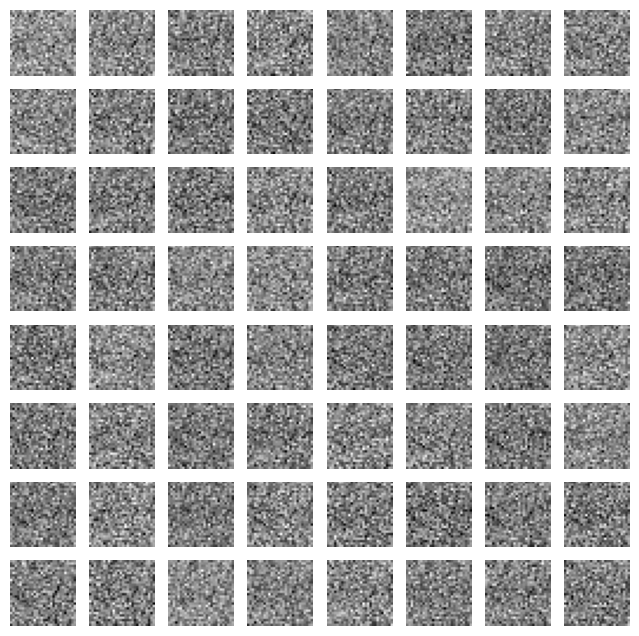

In [23]:
# show samples of fake images generated by the Generator
image_samples = save_images(G, 0, SAMPLES_FOLDER, 64, LATENT_SIZE, DEVICE)

# show the samples here
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(len(image_samples)):
    image = image_samples[i].permute(1, 2, 0)
    image = denorm(image)
    ax[i // 8][i % 8].axis("off")
    _ = ax[i // 8][i % 8].imshow(image.detach().cpu(), cmap="gray")

In [24]:
# train the discriminator and generator models
metrics = train_gan(
    D,
    G,
    LATENT_SIZE,
    dataloader,
    criterion,
    d_optimizer,
    g_optimizer,
    64,
    0,
    EPOCHS,
    DEVICE,
    SAMPLES_FOLDER,
)
D.eval()
G.eval()

Epoch [1/500], Step [117/235], D Loss: 0.6515, G Loss: 1.1844, D Real Accuracy: 0.9883, D Fake Accuracy: 0.0000
Epoch [1/500], Step [234/235], D Loss: 0.3102, G Loss: 2.1928, D Real Accuracy: 0.9961, D Fake Accuracy: 0.0000
Epoch [2/500], Step [117/235], D Loss: 0.1055, G Loss: 3.2167, D Real Accuracy: 1.0000, D Fake Accuracy: 0.0000
Epoch [2/500], Step [234/235], D Loss: 0.5138, G Loss: 1.9763, D Real Accuracy: 0.9336, D Fake Accuracy: 0.0000
Epoch [3/500], Step [117/235], D Loss: 0.2069, G Loss: 3.2840, D Real Accuracy: 0.9766, D Fake Accuracy: 0.0000
Epoch [3/500], Step [234/235], D Loss: 0.0509, G Loss: 3.8617, D Real Accuracy: 1.0000, D Fake Accuracy: 0.0000
Epoch [4/500], Step [117/235], D Loss: 0.0953, G Loss: 3.5185, D Real Accuracy: 0.9922, D Fake Accuracy: 0.0000
Epoch [4/500], Step [234/235], D Loss: 0.1441, G Loss: 3.1711, D Real Accuracy: 0.9766, D Fake Accuracy: 0.0000
Epoch [5/500], Step [117/235], D Loss: 0.0875, G Loss: 3.7967, D Real Accuracy: 0.9883, D Fake Accuracy:

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

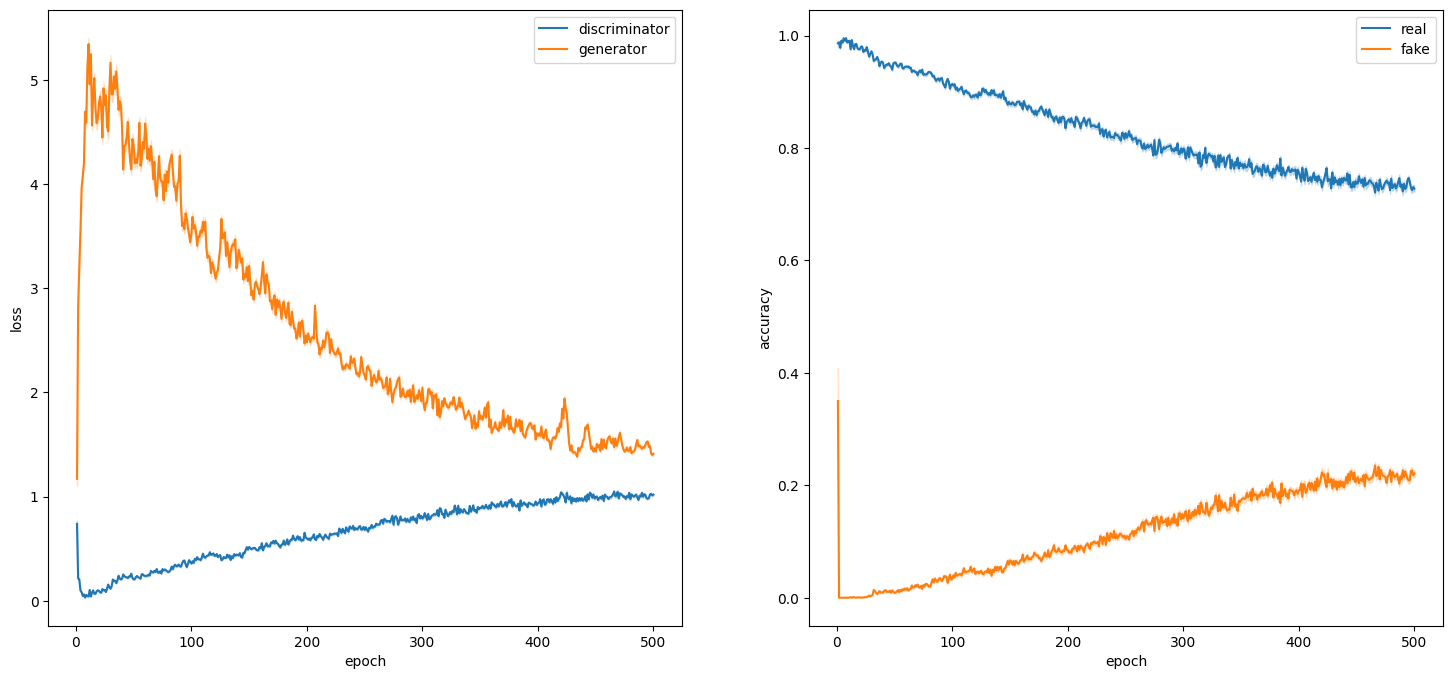

In [25]:
# show the training metrics
metrics = pd.DataFrame(metrics)
metrics.to_csv(os.path.join(WEIGHTS_FOLDER, "metrics_GAN_0.csv"), index=False)
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
_ = sns.lineplot(metrics, x="epoch", y="d_loss", c="tab:blue", legend="brief", label="discriminator", ax=ax[0])
_ = sns.lineplot(metrics, x="epoch", y="g_loss", c="tab:orange", legend="brief", label="generator", ax=ax[0])
_ = ax[0].set_ylabel("loss")
_ = sns.lineplot(metrics, x="epoch", y="d_real_accuracy", c="tab:blue", legend="brief", label="real", ax=ax[1])
_ = sns.lineplot(metrics, x="epoch", y="d_fake_accuracy", c="tab:orange", legend="brief", label="fake", ax=ax[1])
_ = ax[1].set_ylabel("accuracy")
fig.savefig(os.path.join(WEIGHTS_FOLDER, "train_curve_GAN_0.png"), bbox_inches="tight")

#### Step 3 - Generate and save atleast 3 images from your GAN model

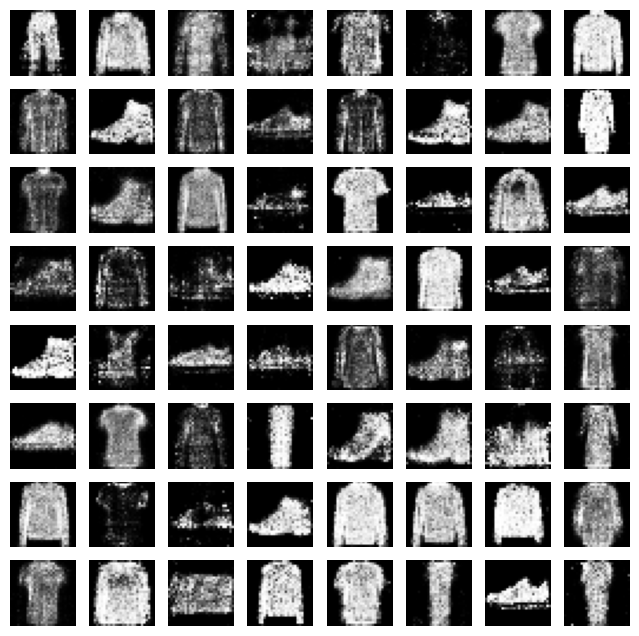

In [26]:
with torch.no_grad():
    image_samples = save_images(G, 1001, SAMPLES_FOLDER, 64, LATENT_SIZE, DEVICE)
    # show the samples here
    fig, ax = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(len(image_samples)):
        image = image_samples[i].permute(1, 2, 0)
        image = denorm(image)
        ax[i // 8][i % 8].axis("off")
        _ = ax[i // 8][i % 8].imshow(image.cpu(), cmap="gray")

##### Describe and discuss any difficulties faced in this process.

1. The current learning rate for the above run was 0.0001. This was updated from 0.0002 as shown in the demo since the models were not converging at that learning rate. This was time consuming since the model had to be run for 500 epochs before it could be identified that the model was not converging.
2. We can see that the Generator is still not generating convincing images of any category from the samples seen above. It has a general idea of jeans, jackets, shoes, and dresses, but the details are missing in the generated images.
3. The generator loss is still decreasing, indicating that the generator is getting better at generating images. The discriminator loss is increasing, which can be seen in the accuracy curves. The accuracy of detecting real images in the discriminator is going down, even though the accuracy of detecting fake images is going up. This will probably stabilize if we train the models for more epochs.

#### Step 4 - Save the model weights (with checkpoints)

In [27]:
torch.save({
    "D_weights": D.state_dict(),
    "G_weights": G.state_dict(),
    "D_optimizer": d_optimizer.state_dict(),
    "G_optimizer": g_optimizer.state_dict(),
    "epoch": EPOCHS,
}, os.path.join(WEIGHTS_FOLDER, "GAN_0.ckpt"))

#### Step 5 - Load the model using the saved weights

In [28]:
# create initial models again
D = create_discriminator(IMG_SIZE, HIDDEN_SIZE, DEVICE)
G = create_generator(LATENT_SIZE, HIDDEN_SIZE, IMG_SIZE, DEVICE)

# create initial optimizers again
d_optimizer = torch.optim.Adam(D.parameters(), lr=LEARNING_RATE)
g_optimizer = torch.optim.Adam(G.parameters(), lr=LEARNING_RATE)

# load the checkpoint and initialize the above models and optimizers again
checkpoint = torch.load(os.path.join(WEIGHTS_FOLDER, "GAN_0.ckpt"))
D.load_state_dict(checkpoint["D_weights"])
G.load_state_dict(checkpoint["G_weights"])
d_optimizer.load_state_dict(checkpoint["D_optimizer"])
g_optimizer.load_state_dict(checkpoint["G_optimizer"])
inital_epoch = checkpoint["epoch"]
end_epoch = inital_epoch + EPOCHS

/var/folders/j1/26nnr5gj74bfpxhb39x2kpr00000gp/T/ipykernel_71111/4119763123.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(WEIGHTS

#### Step 6 - Retrain the GAN Model and observe improvements, if any

In [29]:
# create the dataloader for training
dataloader = torch.utils.data.DataLoader(fashion_mnist, batch_size=BATCH_SIZE, shuffle=True)

In [30]:
# train the discriminator and generator models again
metrics = train_gan(
    D,
    G,
    LATENT_SIZE,
    dataloader,
    criterion,
    d_optimizer,
    g_optimizer,
    64,
    inital_epoch,
    end_epoch,
    DEVICE,
    SAMPLES_FOLDER,
)
D.eval()
G.eval()

Epoch [501/1000], Step [117/235], D Loss: 1.1611, G Loss: 1.4419, D Real Accuracy: 0.6484, D Fake Accuracy: 0.2227
Epoch [501/1000], Step [234/235], D Loss: 1.0622, G Loss: 1.4115, D Real Accuracy: 0.7070, D Fake Accuracy: 0.2578
Epoch [502/1000], Step [117/235], D Loss: 1.0133, G Loss: 1.4828, D Real Accuracy: 0.7227, D Fake Accuracy: 0.2070
Epoch [502/1000], Step [234/235], D Loss: 1.0376, G Loss: 1.4069, D Real Accuracy: 0.7500, D Fake Accuracy: 0.2695
Epoch [503/1000], Step [117/235], D Loss: 0.8808, G Loss: 1.3978, D Real Accuracy: 0.8594, D Fake Accuracy: 0.1992
Epoch [503/1000], Step [234/235], D Loss: 1.0227, G Loss: 1.4925, D Real Accuracy: 0.7656, D Fake Accuracy: 0.2656
Epoch [504/1000], Step [117/235], D Loss: 0.9195, G Loss: 1.5134, D Real Accuracy: 0.7617, D Fake Accuracy: 0.1914
Epoch [504/1000], Step [234/235], D Loss: 0.9655, G Loss: 1.5558, D Real Accuracy: 0.7695, D Fake Accuracy: 0.2188
Epoch [505/1000], Step [117/235], D Loss: 0.9725, G Loss: 1.3229, D Real Accurac

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

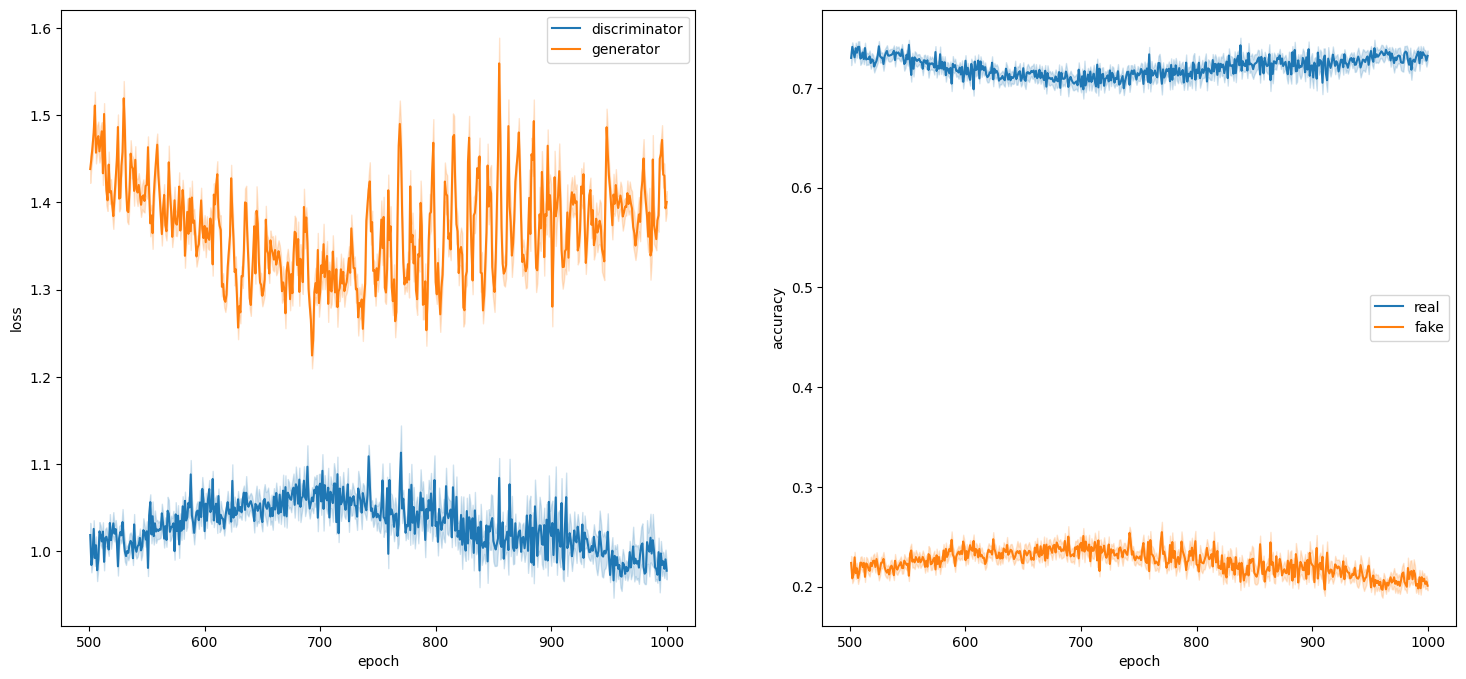

In [31]:
# show the training metrics
metrics = pd.DataFrame(metrics)
metrics.to_csv(os.path.join(WEIGHTS_FOLDER, "metrics_GAN_1.csv"), index=False)
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
_ = sns.lineplot(metrics, x="epoch", y="d_loss", c="tab:blue", legend="brief", label="discriminator", ax=ax[0])
_ = sns.lineplot(metrics, x="epoch", y="g_loss", c="tab:orange", legend="brief", label="generator", ax=ax[0])
_ = ax[0].set_ylabel("loss")
_ = sns.lineplot(metrics, x="epoch", y="d_real_accuracy", c="tab:blue", legend="brief", label="real", ax=ax[1])
_ = sns.lineplot(metrics, x="epoch", y="d_fake_accuracy", c="tab:orange", legend="brief", label="fake", ax=ax[1])
_ = ax[1].set_ylabel("accuracy")
fig.savefig(os.path.join(WEIGHTS_FOLDER, "train_curve_GAN_1.png"), bbox_inches="tight")

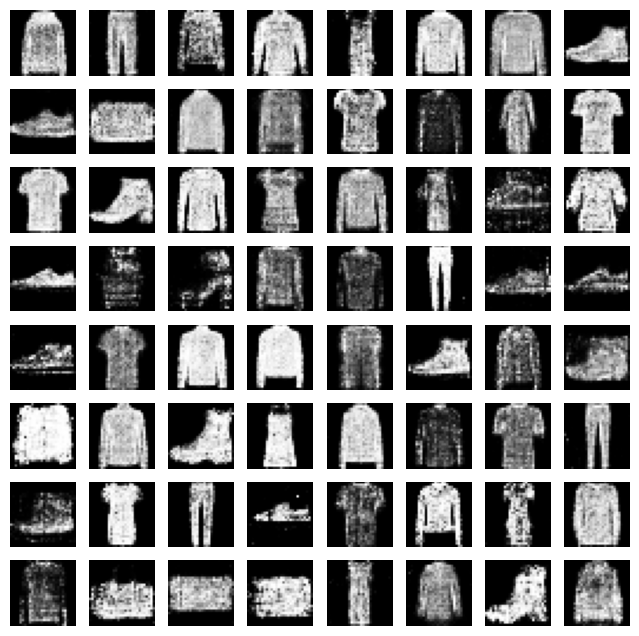

In [32]:
with torch.no_grad():
    image_samples = save_images(G, 1002, SAMPLES_FOLDER, 64, LATENT_SIZE, DEVICE)
    # show the samples here
    fig, ax = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(len(image_samples)):
        image = image_samples[i].permute(1, 2, 0)
        image = denorm(image)
        ax[i // 8][i % 8].axis("off")
        _ = ax[i // 8][i % 8].imshow(image.cpu(), cmap="gray")

##### Improvements

1. There is no general improvement in the quality of images generated by the model. It is able to generate images that generally look like shirts, shoes, jeans and dresses.
2. There is a huge variation in the generator loss at around 750 epochs, and the generator loss started increasing after that.
3. The discriminator loss also started decreasing at around the same time, and correspondingly the real image accuracy started increasing and the fake image accuracy started decreasing. This is indicating that the model is getting better at identifying the real images, but the generator is also getting better at producing images, causing the fake image accuracy to go down.
4. Overall, there wasn't much change in the accuracy metrics for discriminator in these 500 epochs of training after reloading the model.

#### Step 7 - Save the model without using checkpoints

In [33]:
torch.save(D.state_dict(), os.path.join(WEIGHTS_FOLDER, "D_GAN_1.pt"))
torch.save(G.state_dict(), os.path.join(WEIGHTS_FOLDER, "G_GAN_1.pt"))

#### Step 8 - Load the model without using checkpoints

In [34]:
# create initial models again
D = create_discriminator(IMG_SIZE, HIDDEN_SIZE, DEVICE)
G = create_generator(LATENT_SIZE, HIDDEN_SIZE, IMG_SIZE, DEVICE)

# load the model weights from saved weights
D.load_state_dict(torch.load(os.path.join(WEIGHTS_FOLDER, "D_GAN_1.pt"), weights_only=True))
G.load_state_dict(torch.load(os.path.join(WEIGHTS_FOLDER, "G_GAN_1.pt"), weights_only=True))
D.eval()
G.eval()

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

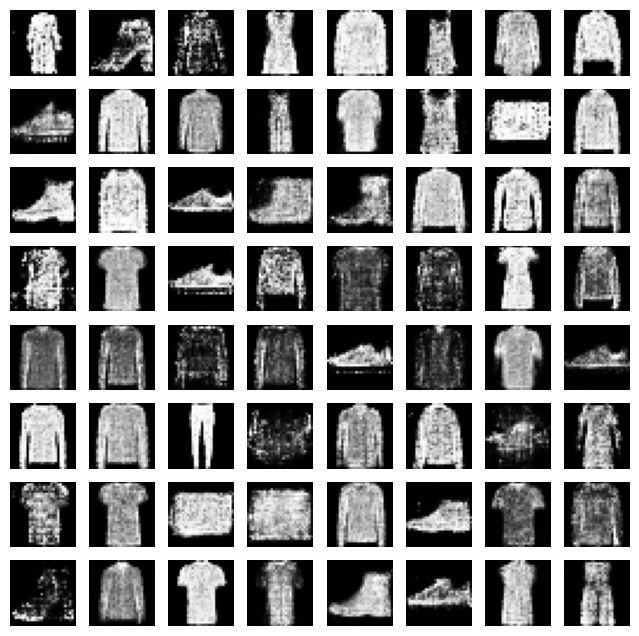

In [35]:
with torch.no_grad():
    image_samples = save_images(G, 1003, SAMPLES_FOLDER, 64, LATENT_SIZE, DEVICE)
    # show the samples here
    fig, ax = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(len(image_samples)):
        image = image_samples[i].permute(1, 2, 0)
        image = denorm(image)
        ax[i // 8][i % 8].axis("off")
        _ = ax[i // 8][i % 8].imshow(image.cpu(), cmap="gray")

### Part 2 - LSGAN

#### Step 1 - Load the Dataset and Create the models

In [36]:
def create_ls_discriminator(img_size, hidden_size, device):
    model = torch.nn.Sequential(
        torch.nn.Linear(in_features=img_size, out_features=hidden_size),
        torch.nn.LeakyReLU(negative_slope=0.2),
        torch.nn.Linear(in_features=hidden_size, out_features=hidden_size),
        torch.nn.LeakyReLU(negative_slope=0.2),
        torch.nn.Linear(in_features=hidden_size, out_features=1),
        # torch.nn.Sigmoid() - there is no sigmoid layer in LSGAN
    )
    # move the model to GPU
    model.to(device)
    return model

In [37]:
# define the Discriminator
D = create_ls_discriminator(IMG_SIZE, HIDDEN_SIZE, DEVICE)

In [38]:
def create_ls_generator(latent_size, hidden_size, img_size, device):
    model = torch.nn.Sequential(
        torch.nn.Linear(in_features=latent_size, out_features=hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=hidden_size, out_features=hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=hidden_size, out_features=img_size),
        torch.nn.Tanh(),
    )
    # move the model to GPU
    model.to(device)
    return model

In [39]:
# define the Generator
G = create_ls_generator(LATENT_SIZE, HIDDEN_SIZE, IMG_SIZE, DEVICE)

Shape of random latent vectors - torch.Size([2, 64])


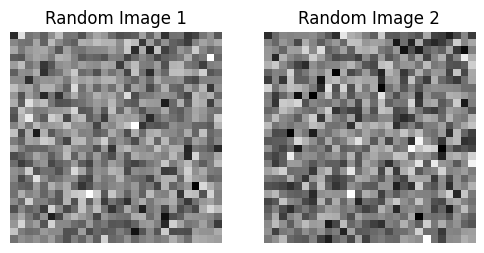

In [40]:
# generate 2 random latent vector of size LATENT_SIZE
random_latent_vectors = torch.randn((2, LATENT_SIZE)).to(DEVICE)
print(f"Shape of random latent vectors - {random_latent_vectors.shape}")
# generate images from the latent vectors
imgs = G(random_latent_vectors)
imgs = denorm(imgs)
imgs = imgs.reshape((2, 1, 28, 28)).permute(0, 2, 3, 1).to("cpu").detach()
# show the random images
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].set_title("Random Image 1")
ax[0].axis("off")
_ = ax[0].imshow(imgs[0], cmap="gray")
ax[1].set_title("Random Image 2")
ax[1].axis("off")
_ = ax[1].imshow(imgs[1], cmap="gray")

#### Step 2 - Train the discriminator and generator

In [41]:
SAMPLES_FOLDER = "lsgan_samples"

In [42]:
# create the samples folder and weights folder
os.makedirs(SAMPLES_FOLDER, exist_ok=True)
os.makedirs(WEIGHTS_FOLDER, exist_ok=True)

In [43]:
# define the optimizers
criterion = torch.nn.MSELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=LEARNING_RATE)
g_optimizer = torch.optim.Adam(G.parameters(), lr=LEARNING_RATE)

In [44]:
# function to train the discriminator and generator
def train_lsgan(
    discriminator,
    generator,
    latent_size,
    dataloader,
    criterion,
    d_optimizer,
    g_optimizer,
    t_batch_size,
    start_epochs,
    end_epochs,
    device,
    samples_folder,
):
    metrics = {
        "epoch": [],
        "step": [],
        "d_loss": [],
        "g_loss": [],
        "d_real_accuracy": [],
        "d_fake_accuracy": [],
    }

    total_steps = len(dataloader)

    for epoch in range(start_epochs, end_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            # get the number of samples in this batch
            batch_size = real_images.size(0)
            # reshape the batch - example [10, 1, 28, 28] to [10, 784]
            real_images = real_images.view(batch_size, -1)
            # move the tensor to GPU
            real_images = real_images.to(device)

            # train discriminator
            d_optimizer.zero_grad()
            # labels for real images
            real_labels = torch.ones(batch_size, 1)
            # move real labels to GPU
            real_labels = real_labels.to(device)
            # predictions on the real images
            d_real_output = discriminator(real_images)
            # loss on the real images
            d_real_loss = criterion(d_real_output, real_labels)
            # latent vectors for fake images
            z = torch.randn(batch_size, latent_size)
            # move latent vector to GPU
            z = z.to(device)
            # fake images
            fake_images = generator(z)
            # labels for fake images
            fake_labels = torch.zeros(batch_size, 1)
            # move fake labels to GPU
            fake_labels = fake_labels.to(device)
            # predictions on the fake images (detach to stop gradient updates)
            d_fake_output = discriminator(fake_images.detach())
            # loss on the fake images
            d_fake_loss = criterion(d_fake_output, fake_labels)
            # combined loss
            d_loss = d_real_loss + d_fake_loss
            # calculate gradients
            d_loss.backward()
            # propagate loss backwards
            d_optimizer.step()

            # train generator
            g_optimizer.zero_grad()
            # predictions on the fake images
            g_output = discriminator(fake_images)
            # loss on the fake images
            g_loss = criterion(g_output, real_labels)
            # calculate gradients
            g_loss.backward()
            # propagate loss backwards
            g_optimizer.step()

            # calculate metrics
            d_real_accuracy = (
                ((d_real_output > 0.5).float() == real_labels).float().mean()
            )
            d_fake_accuracy = (
                ((d_fake_output < 0.5).float() == fake_labels).float().mean()
            )

            # log metrics
            metrics["epoch"].append(epoch + 1)
            metrics["step"].append(i + 1)
            metrics["d_loss"].append(d_loss.item())
            metrics["g_loss"].append(g_loss.item())
            metrics["d_real_accuracy"].append(d_real_accuracy.item())
            metrics["d_fake_accuracy"].append(d_fake_accuracy.item())

            # print progress
            if (i + 1) % (total_steps // 2) == 0:
                print(
                    f"Epoch [{epoch+1}/{end_epochs}],",
                    f"Step [{i+1}/{total_steps}],",
                    f"D Loss: {d_loss.item():.4f},",
                    f"G Loss: {g_loss.item():.4f},",
                    f"D Real Accuracy: {d_real_accuracy.item():.4f},",
                    f"D Fake Accuracy: {d_fake_accuracy.item():.4f}",
                )
        # save fake samples for progress
        _ = save_images(
            generator, epoch + 1, samples_folder, t_batch_size, latent_size, device
        )

    return metrics

In [45]:
# create the dataloader for training
dataloader = torch.utils.data.DataLoader(fashion_mnist, batch_size=BATCH_SIZE, shuffle=True)

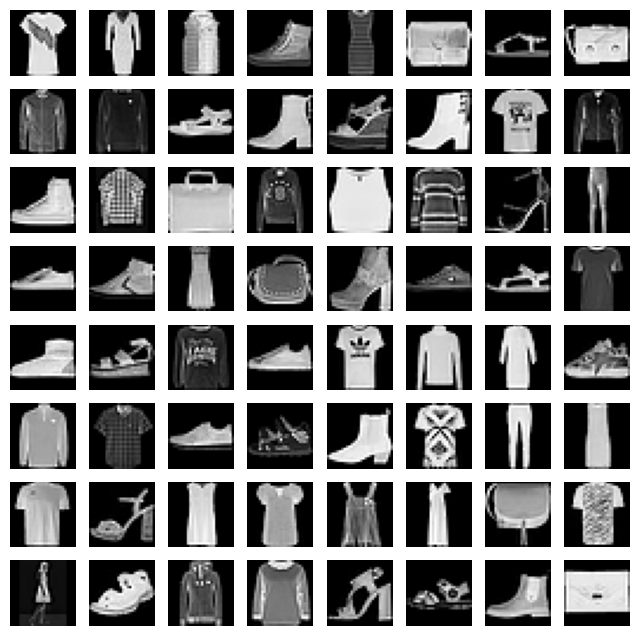

In [46]:
# save samples of real_images
real_image_path = os.path.join(SAMPLES_FOLDER, "real_images.png")
image_samples = None
for images, _ in dataloader:
    images = images.reshape(-1, 1, 28, 28)
    torchvision.utils.save_image(denorm(images[:64]), real_image_path, nrow=8)
    image_samples = images[:64]
    break

# show the samples here
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(len(image_samples)):
    image = image_samples[i].permute(1, 2, 0)
    image = denorm(image)
    ax[i // 8][i % 8].axis("off")
    _ = ax[i // 8][i % 8].imshow(image, cmap="gray")

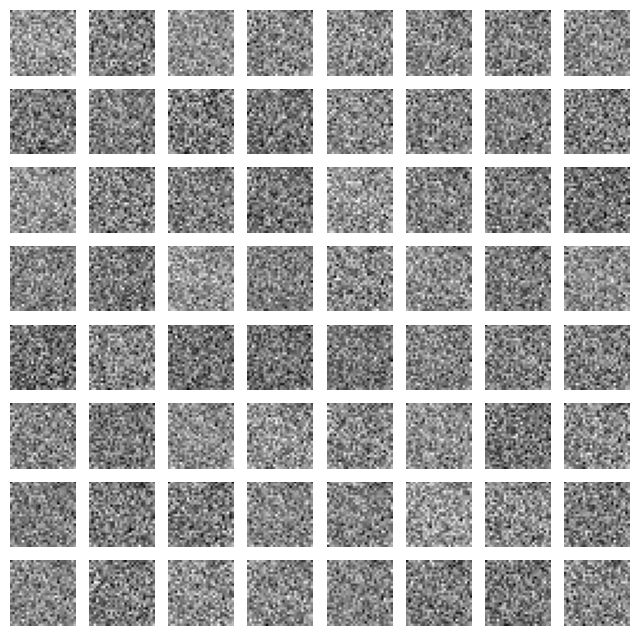

In [47]:
# show samples of fake images generated by the Generator
image_samples = save_images(G, 0, SAMPLES_FOLDER, 64, LATENT_SIZE, DEVICE)

# show the samples here
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(len(image_samples)):
    image = image_samples[i].permute(1, 2, 0)
    image = denorm(image)
    ax[i // 8][i % 8].axis("off")
    _ = ax[i // 8][i % 8].imshow(image.detach().cpu(), cmap="gray")

In [48]:
# train the discriminator and generator models
metrics = train_lsgan(
    D,
    G,
    LATENT_SIZE,
    dataloader,
    criterion,
    d_optimizer,
    g_optimizer,
    64,
    0,
    EPOCHS,
    DEVICE,
    SAMPLES_FOLDER,
)
D.eval()
G.eval()

Epoch [1/500], Step [117/235], D Loss: 0.0357, G Loss: 1.0326, D Real Accuracy: 1.0000, D Fake Accuracy: 0.0000
Epoch [1/500], Step [234/235], D Loss: 0.0205, G Loss: 1.1907, D Real Accuracy: 0.9961, D Fake Accuracy: 0.0000
Epoch [2/500], Step [117/235], D Loss: 0.0106, G Loss: 1.1307, D Real Accuracy: 1.0000, D Fake Accuracy: 0.0000
Epoch [2/500], Step [234/235], D Loss: 0.0067, G Loss: 1.0887, D Real Accuracy: 1.0000, D Fake Accuracy: 0.0000
Epoch [3/500], Step [117/235], D Loss: 0.0168, G Loss: 1.1903, D Real Accuracy: 1.0000, D Fake Accuracy: 0.0000
Epoch [3/500], Step [234/235], D Loss: 0.0079, G Loss: 1.1426, D Real Accuracy: 1.0000, D Fake Accuracy: 0.0000
Epoch [4/500], Step [117/235], D Loss: 0.0094, G Loss: 1.0606, D Real Accuracy: 1.0000, D Fake Accuracy: 0.0000
Epoch [4/500], Step [234/235], D Loss: 0.0124, G Loss: 1.0351, D Real Accuracy: 1.0000, D Fake Accuracy: 0.0000
Epoch [5/500], Step [117/235], D Loss: 0.0182, G Loss: 1.1475, D Real Accuracy: 0.9922, D Fake Accuracy:

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

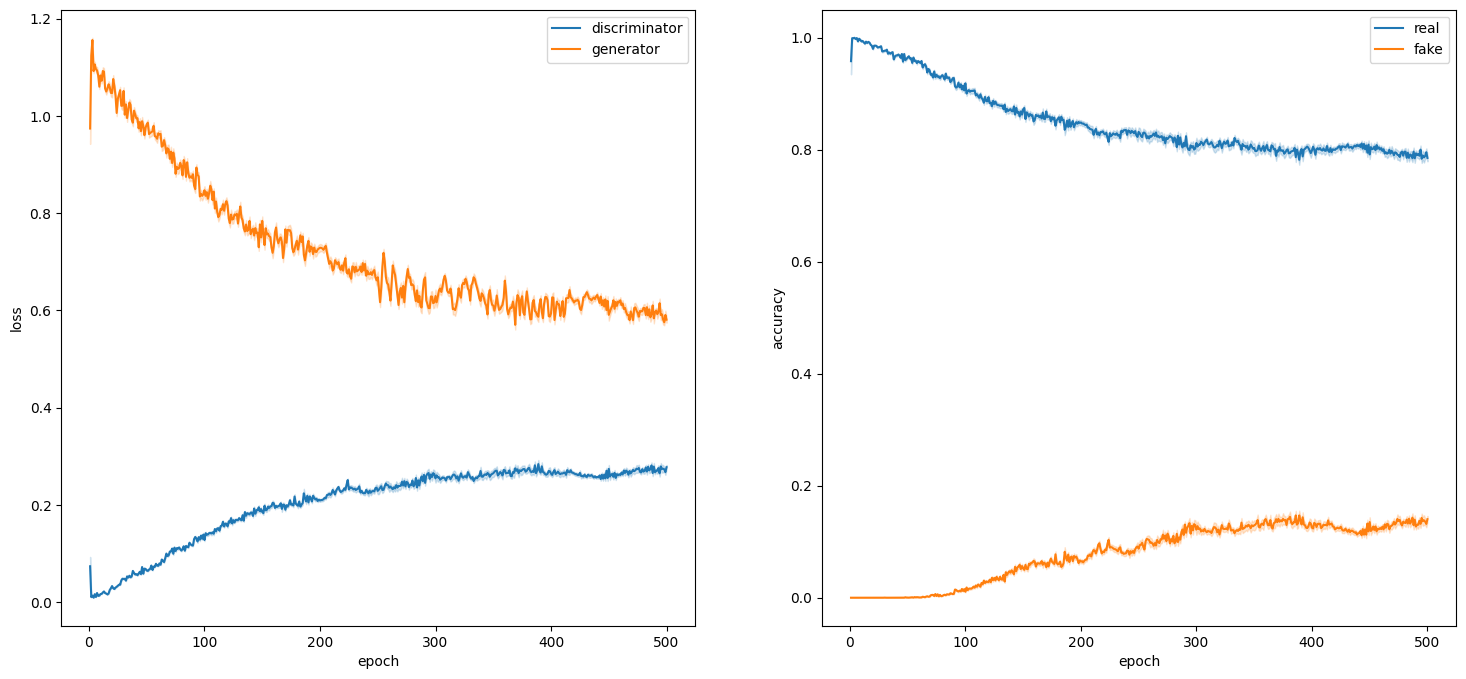

In [49]:
# show the training metrics
metrics = pd.DataFrame(metrics)
metrics.to_csv(os.path.join(WEIGHTS_FOLDER, "metrics_LSGAN_0.csv"), index=False)
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
_ = sns.lineplot(metrics, x="epoch", y="d_loss", c="tab:blue", legend="brief", label="discriminator", ax=ax[0])
_ = sns.lineplot(metrics, x="epoch", y="g_loss", c="tab:orange", legend="brief", label="generator", ax=ax[0])
_ = ax[0].set_ylabel("loss")
_ = sns.lineplot(metrics, x="epoch", y="d_real_accuracy", c="tab:blue", legend="brief", label="real", ax=ax[1])
_ = sns.lineplot(metrics, x="epoch", y="d_fake_accuracy", c="tab:orange", legend="brief", label="fake", ax=ax[1])
_ = ax[1].set_ylabel("accuracy")
fig.savefig(os.path.join(WEIGHTS_FOLDER, "train_curve_LSGAN_0.png"), bbox_inches="tight")

#### Step 3 - Generate and save atleast 3 images from the generator

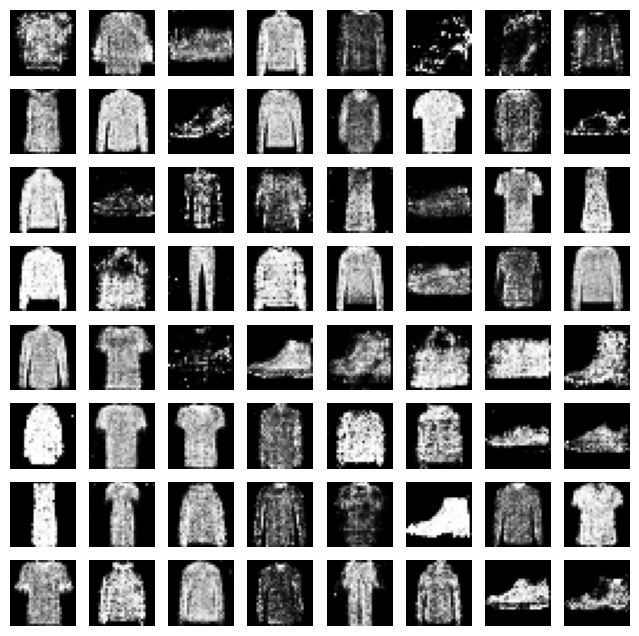

In [50]:
with torch.no_grad():
    image_samples = save_images(G, 1001, SAMPLES_FOLDER, 64, LATENT_SIZE, DEVICE)
    # show the samples here
    fig, ax = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(len(image_samples)):
        image = image_samples[i].permute(1, 2, 0)
        image = denorm(image)
        ax[i // 8][i % 8].axis("off")
        _ = ax[i // 8][i % 8].imshow(image.cpu(), cmap="gray")

##### Describe and discuss any difficulties faced in this process.

1. We can see that the Generator is still not generating convincing images of any category from the samples seen above. It has a general idea of jeans, jackets, shoes, and dresses, but the details are missing in the generated images.
2. The generator loss is decreasing gradually, indicating that the generator is getting better at generating images, but slowly. The discriminator loss is increasing, which can be seen in the accuracy curves. The accuracy of detecting real images in the discriminator is going down, even though the accuracy of detecting fake images is going up. This will probably stabilize if we train the models for more epochs.
3. Overall, the discriminator and generator losses are lower than a Normal GAN.
4. The real and fake image accuracy is very similar to Normal GAN.

#### Step 4 - Save the model weights in the folder to be used later

In [51]:
torch.save({
    "D_weights": D.state_dict(),
    "G_weights": G.state_dict(),
    "D_optimizer": d_optimizer.state_dict(),
    "G_optimizer": g_optimizer.state_dict(),
    "epoch": EPOCHS,
}, os.path.join(WEIGHTS_FOLDER, "LSGAN_0.ckpt"))

#### Step 5 - Load the model using the saved weights

In [52]:
# create initial models again
D = create_ls_discriminator(IMG_SIZE, HIDDEN_SIZE, DEVICE)
G = create_ls_generator(LATENT_SIZE, HIDDEN_SIZE, IMG_SIZE, DEVICE)

# create initial optimizers again
d_optimizer = torch.optim.Adam(D.parameters(), lr=LEARNING_RATE)
g_optimizer = torch.optim.Adam(G.parameters(), lr=LEARNING_RATE)

# load the checkpoint and initialize the above models and optimizers again
checkpoint = torch.load(os.path.join(WEIGHTS_FOLDER, "LSGAN_0.ckpt"))
D.load_state_dict(checkpoint["D_weights"])
G.load_state_dict(checkpoint["G_weights"])
d_optimizer.load_state_dict(checkpoint["D_optimizer"])
g_optimizer.load_state_dict(checkpoint["G_optimizer"])
inital_epoch = checkpoint["epoch"]
end_epoch = inital_epoch + EPOCHS

/var/folders/j1/26nnr5gj74bfpxhb39x2kpr00000gp/T/ipykernel_71111/2708817563.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(WEIGHTS

#### Step 6 - Retrain the GAN model and observe improvements, if any

In [53]:
# create the dataloader for training
dataloader = torch.utils.data.DataLoader(fashion_mnist, batch_size=BATCH_SIZE, shuffle=True)

In [54]:
# train the discriminator and generator models again
metrics = train_lsgan(
    D,
    G,
    LATENT_SIZE,
    dataloader,
    criterion,
    d_optimizer,
    g_optimizer,
    64,
    inital_epoch,
    end_epoch,
    DEVICE,
    SAMPLES_FOLDER,
)
D.eval()
G.eval()

Epoch [501/1000], Step [117/235], D Loss: 0.3676, G Loss: 0.5256, D Real Accuracy: 0.6914, D Fake Accuracy: 0.2031
Epoch [501/1000], Step [234/235], D Loss: 0.3185, G Loss: 0.5344, D Real Accuracy: 0.7852, D Fake Accuracy: 0.1914
Epoch [502/1000], Step [117/235], D Loss: 0.2634, G Loss: 0.5465, D Real Accuracy: 0.8242, D Fake Accuracy: 0.1211
Epoch [502/1000], Step [234/235], D Loss: 0.2224, G Loss: 0.6401, D Real Accuracy: 0.8750, D Fake Accuracy: 0.0820
Epoch [503/1000], Step [117/235], D Loss: 0.2221, G Loss: 0.6588, D Real Accuracy: 0.8320, D Fake Accuracy: 0.0859
Epoch [503/1000], Step [234/235], D Loss: 0.2507, G Loss: 0.6678, D Real Accuracy: 0.7891, D Fake Accuracy: 0.0742
Epoch [504/1000], Step [117/235], D Loss: 0.2590, G Loss: 0.6222, D Real Accuracy: 0.8555, D Fake Accuracy: 0.1641
Epoch [504/1000], Step [234/235], D Loss: 0.2785, G Loss: 0.5427, D Real Accuracy: 0.8125, D Fake Accuracy: 0.1367
Epoch [505/1000], Step [117/235], D Loss: 0.2230, G Loss: 0.6633, D Real Accurac

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

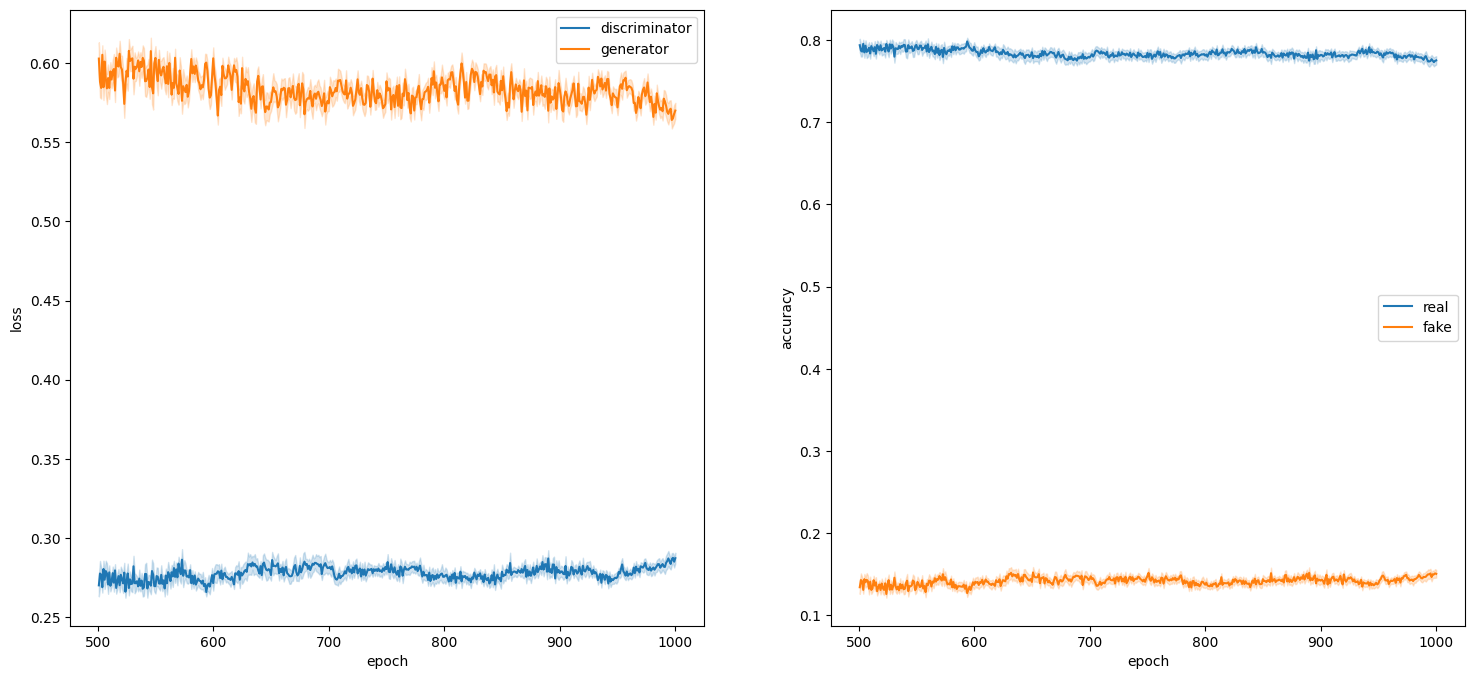

In [55]:
# show the training metrics
metrics = pd.DataFrame(metrics)
metrics.to_csv(os.path.join(WEIGHTS_FOLDER, "metrics_LSGAN_1.csv"), index=False)
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
_ = sns.lineplot(metrics, x="epoch", y="d_loss", c="tab:blue", legend="brief", label="discriminator", ax=ax[0])
_ = sns.lineplot(metrics, x="epoch", y="g_loss", c="tab:orange", legend="brief", label="generator", ax=ax[0])
_ = ax[0].set_ylabel("loss")
_ = sns.lineplot(metrics, x="epoch", y="d_real_accuracy", c="tab:blue", legend="brief", label="real", ax=ax[1])
_ = sns.lineplot(metrics, x="epoch", y="d_fake_accuracy", c="tab:orange", legend="brief", label="fake", ax=ax[1])
_ = ax[1].set_ylabel("accuracy")
fig.savefig(os.path.join(WEIGHTS_FOLDER, "train_curve_LSGAN_1.png"), bbox_inches="tight")

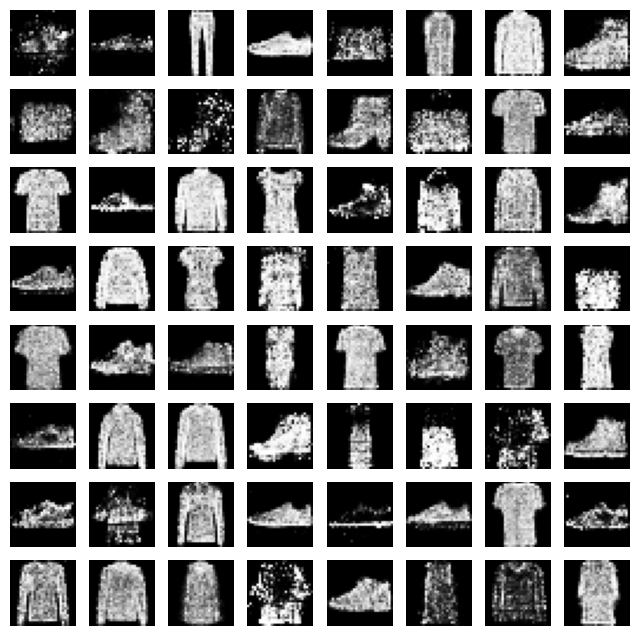

In [56]:
with torch.no_grad():
    image_samples = save_images(G, 1002, SAMPLES_FOLDER, 64, LATENT_SIZE, DEVICE)
    # show the samples here
    fig, ax = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(len(image_samples)):
        image = image_samples[i].permute(1, 2, 0)
        image = denorm(image)
        ax[i // 8][i % 8].axis("off")
        _ = ax[i // 8][i % 8].imshow(image.cpu(), cmap="gray")

##### Improvements

1. There is no general improvement in the quality of images generated by the model. It is able to generate images that generally look like shirts, shoes, jeans and dresses.
2. The generator and discriminator losses over the epochs are quite stable. Only the generator loss decreased by a very slight margin.
3. The real and fake image accuracy is nearly the same after training the model for 500 more epochs.
4. Overall, the image quality and metrics didn't improve even after training the model for 500 more epochs.

#### Result Comparisions

| Model | First 500 epochs | Next 500 epochs |
| :---: | :---: | :---: |
| **GAN** | ![GAN500](weights/train_curve_GAN_0.png) | ![GAN1000](weights/train_curve_GAN_1.png) |
| **LSGAN** | ![LSGAN500](weights/train_curve_LSGAN_0.png) | ![LSGAN1000](weights/train_curve_LSGAN_1.png) |

---

| Model | GAN | LSGAN |
| :---: | :---: | :---: |
| **Images after 1000 epochs** | ![Images](gan_samples/fake_images-1002.png) | ![Images](lsgan_samples/fake_images-1002.png) |

1. LSGAN achieved better loss compared to GAN, and had a higher real image accuracy at the end of 1000 epochs (0.7 for GAN, 0.8 for LSGAN).
2. GAN achieved a higher fake accuracy compared in the discriminator compared to LSGAN.
3. Training the models for more epochs will give better results, although it seems LSGAN has stabilised and won't improve much. On the other hand, GAN is still not stabilized and has the capability to improve upon further training.
4. Viually, the samples from GAN look more defined and clear compared to LSGAN.